In [129]:
import pyaudio
import wave
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import random

from scipy.io.wavfile import read
import scipy

from random import random
import math
from numpy.linalg import inv
from scipy.linalg import toeplitz

import wave, os, glob

from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator as pchip

import librosa

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from pycm import *
from sklearn.svm import SVC

import time

from termcolor import colored

### EMODB DATASET DESCRIPTION

1. 6 basics emotions- W-anger, L-boredom, E-disgust, A-anxiety, F-happiness, T-sadness, N-neutral

2. 5F, 5M (10 utterences, 5 short & 5 longer)

3. filename = 03a01Fa.wav --> 03-a01-F-a.wav
              03--> speaker detail(M,31 year old) others are [08,09,10,11,12,13,14,15,16]
              a01--> code for text
              F--> emotion code
              a--> if there are more than 2 versions (there are no. a,b,c...)

In [130]:
## SPLITTING TRAINING & TESTING DATASET 

fs=8000

X_data = []
Y_data = []

#X_test = []
#Y_test = []

path = 'C:/emodb_new/wav'
for filename in glob.glob(os.path.join(path, '*.wav')):
    
    samplerate, data = scipy.io.wavfile.read(filename,mmap=False)
    #data, sampling_rate = librosa.load(filename)
    
    """
    # selecting speaker 15 & 16 for testing dataset
    
    if(filename[17:19]=='15' or filename[17:19]=='16'):
        X_test.append(data)
        if (filename[22]=='W'):
            Y_test.append(0)  
        elif(filename[22]=='L'):
            Y_test.append(1)
        elif(filename[22]=='E'):
            Y_test.append(2)
        elif(filename[22]=='A'):
            Y_test.append(3)
        elif(filename[22]=='F'):
            Y_test.append(4)
        elif(filename[22]=='T'):
            Y_test.append(5)
        else:                                #(filename[22]=='N')
            Y_test.append(6)
    else:
    """
    ### normalizing speech data to (-1,1)
    dt=data/(max(data))
    X_data.append(dt)
    if (filename[22]=='W'):
        Y_data.append(0)  
    elif(filename[22]=='L'):
        Y_data.append(1)
    elif(filename[22]=='E'):
        Y_data.append(2)
    elif(filename[22]=='A'):
        Y_data.append(3)
    elif(filename[22]=='F'):
        Y_data.append(4)
    elif(filename[22]=='T'):
        Y_data.append(5)
    else:                                #(filename[22]=='N')
        Y_data.append(6)
        

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [153]:
filename

'C:/emodb_new/wav\\16b10Wb.wav'

In [156]:
kk='/content/drive/My Drive/MTP Project code /emodb/wav/09a04La.wav'
len(kk)

63

In [159]:
kk[57]

'L'

### Pre-emphasis of the speech signal

In [ ]:
alpha = 0.94
X_pre_emp = X_data

for i in range(len(X_data)):
    for j in range(1,len(X_data[i])):
        X_pre_emp[i][j]=X_data[i][j]-0.94*X_data[i][j-1]


Text(0.5, 1.0, 'Pre-emphasis wav file')

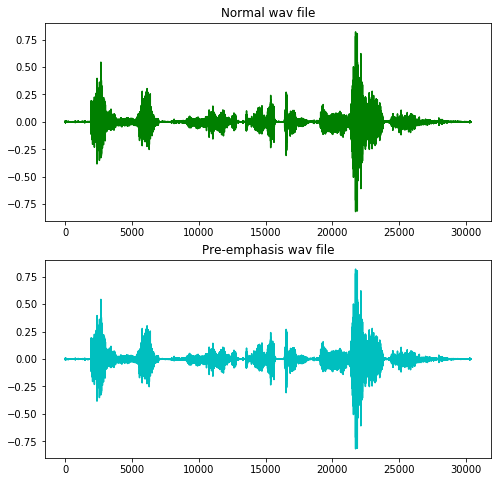

In [88]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.plot(X_data[0], color='g')
plt.title("Normal wav file")

plt.subplot(2,1,2)
plt.plot(X_pre_emp[0], color='c')
plt.title("Pre-emphasis wav file")

#### python_speech_features.base.mfcc(signal, samplerate=16000, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=512, lowfreq=0, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=<function <lambda>>)
1. signal – the audio signal from which to compute features. Should be an N*1 array
2. samplerate – the samplerate of the signal we are working with.
3. winlen – the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
4. winstep – the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
5. numcep – the number of cepstrum to return, default 13
6. nfilt – the number of filters in the filterbank, default 26.
7. nfft – the FFT size. Default is 512.
8. lowfreq – lowest band edge of mel filters. In Hz, default is 0.
9. highfreq – highest band edge of mel filters. In Hz, default is samplerate/2
10. preemph – apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
11. ceplifter – apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
12. appendEnergy – if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
13. winfunc – the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming

In [131]:
from python_speech_features import mfcc
from python_speech_features import logfbank
from python_speech_features.sigproc import preemphasis
from python_speech_features.base import delta
from python_speech_features.base import fbank
from python_speech_features.sigproc import framesig


#### inbuilt pre-emphasis function

In [132]:
X_pre_emphasis = []

for i in range(len(X_data)):
    X_pre_emphasis.append(preemphasis(X_data[i], coeff=0.94))

In [107]:
X_pre_emphasis

[array([ 0.00067141,  0.001189  , -0.00319297, ...,  0.00227019,
        -0.00184123,  0.00134387]),
 array([ 0.00029366, -0.00073023,  0.00144551, ..., -0.00230993,
         0.00256174, -0.00259296]),
 array([ 0.00000000e+00,  3.12744332e-05, -2.44566067e-04, ...,
        -1.75118495e-03,  1.66856557e-03, -1.30495891e-03]),
 array([ 7.02161436e-04,  5.23262914e-04, -1.27079008e-03, ...,
        -3.20022817e-05, -2.48964812e-05, -6.84025623e-05]),
 array([ 6.86200508e-05, -5.36608797e-04,  1.09915597e-03, ...,
        -3.13425869e-03,  2.70820834e-03, -2.45512361e-03]),
 array([ 0.        ,  0.        ,  0.0002886 , ...,  0.0182175 ,
        -0.01816833,  0.01778819]),
 array([ 0.00265511, -0.00428297,  0.00681375, ..., -0.0029072 ,
         0.00256879, -0.00221474]),
 array([ 9.15695013e-05, -1.36133325e-04,  1.21299066e-04, ...,
         5.42465637e-04, -2.74852245e-04,  1.35915138e-05]),
 array([ 0.0001688 , -0.0022316 ,  0.00468366, ..., -0.00116161,
         0.00127545, -0.0014389

In [109]:
len(X_pre_emphasis)

535

In [133]:
def feature_vector(X_data):    
    N_data=len(X_data)
    fs=8000   ## fs=8 kHz
    feat_size = 42

    feature_vect = np.zeros((N_data, feat_size))

    mfcc_coeff = np.zeros((N_data, 13))
    delta_coeff = np.zeros((N_data, 13))
    delta_delta_coeff = np.zeros((N_data, 13))
    frame_energy = np.zeros((N_data,3))

    ## using a 30-ms Hamming window with 7.5-ms step.
    for i in range (len(X_data)):

        mfcc_feat = mfcc( X_data[i], samplerate = 8000, winlen=0.03, winstep=0.0075, winfunc=np.hamming) 
        delta_feat = delta(mfcc_feat, N = mfcc_feat.shape[0])
        delta_delta_feat = delta(delta_feat, N = mfcc_feat.shape[0])
        #fbank_feat = logfbank(sig,rate)

        mfcc_coeff[i,:] = np.mean(mfcc_feat, axis = 0 )
        delta_coeff[i,:] = np.mean(delta_feat, axis = 0)
        delta_delta_coeff[i,:] = np.mean(delta_delta_feat, axis = 0)

        ## calculating frame energies

        frame_len = 0.03*fs
        frames = framesig(X_data[i], frame_len, frame_step= frame_len/2, winfunc=np.hamming)
        energy=np.zeros(len(frames))
        for j in range(len(frames)):
            energy[j]=np.dot(frames[j],frames[j])

        max_frame = max(energy)
        min_frame = max(energy)
        avg_frame = np.mean(energy)

        frame_energy[i,:] = [avg_frame, min_frame, max_frame]

        feature_vect[i,:] = np.hstack((mfcc_coeff[i,:], delta_coeff[i,:], delta_delta_coeff[i,:],
                                     frame_energy[i,:]))
        
    return feature_vect


In [134]:
feature_vect = feature_vector(X_data)

feature_pre_emp = feature_vector(X_pre_emphasis)

In [135]:
import pandas
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import numpy as np

In [90]:
# Import GridsearchCV from Scikit Learn

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [136]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(feature_vect)
y = np.asarray(Y_data)

X_pre_emp = scaler.fit_transform(feature_pre_emp)
y_pre_emp = np.asarray(Y_data)

In [137]:
## test train split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=27)

X_train_pre_emp, X_test_pre_emp, y_train_pre_emp, y_test_pre_emp = train_test_split(X_pre_emp,y_pre_emp,test_size=0.2,random_state=27)

In [138]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}

In [141]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv = 5)
grid.fit(X_train,y_train)

grid_pre_emp = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv = 5)
grid_pre_emp.fit(X_train_pre_emp,y_train_pre_emp)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] .

[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] .................... C=1, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] .................... C=1, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] .

[CV] .................. C=10, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] .................... C=10, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] .

[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    4.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] .................. C=0.1, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] .................. C=0.1, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] .................. C=0.1, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] .................. C=0.1, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] .................. C=0.1, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV] .

[CV] ..................... C=1, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ..................... C=1, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ..................... C=1, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ..................... C=1, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ..................... C=1, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .

[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] .................. C=10, gamma=0.01, kernel=linear, total=   0.0s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] .

[CV] .................. C=100, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] .................. C=100, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] .................. C=100, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    4.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [142]:
print(colored("The Hyper-parameter tuning for Normal speech signal", 'green', 'on_yellow'))
print(grid.best_estimator_, "\n")       ## found the best estimator using grid search

print(colored("The Hyper-parameter tuning for pre-emphasis speech signal", 'green', 'on_yellow'))
print(grid_pre_emp.best_estimator_)

The Hyper-parameter tuning for Normal speech signal
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 

The Hyper-parameter tuning for pre-emphasis speech signal
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [102]:
### for Normal speech signal
print(colored("The Hyper-parameter tuning for Normal speech signal", 'green', 'on_yellow'), "\n")

grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))
print(grid.score(X_test,y_test),"\n")

### for pre-emphasis speech signal
print(colored("The Hyper-parameter tuning for pre-emphasis speech signal", 'green', 'on_yellow'), "\n")

grid_predictions_pre_emp = grid_pre_emp.predict(X_test_pre_emp)
print(confusion_matrix(y_test_pre_emp, grid_predictions_pre_emp))
print(classification_report(y_test_pre_emp, grid_predictions_pre_emp))
print(grid_pre_emp.score(X_test_pre_emp,y_test_pre_emp))

The Hyper-parameter tuning for Normal speech signal 

[[24  0  0  1  0  0  1]
 [ 0  8  0  0  0  0  3]
 [ 0  0  6  0  0  1  0]
 [ 0  1  0 10  1  0  0]
 [ 6  0  0  2  9  0  0]
 [ 0  3  0  0  0 10  1]
 [ 0  4  0  0  0  0 16]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        26
           1       0.50      0.73      0.59        11
           2       1.00      0.86      0.92         7
           3       0.77      0.83      0.80        12
           4       0.90      0.53      0.67        17
           5       0.91      0.71      0.80        14
           6       0.76      0.80      0.78        20

    accuracy                           0.78       107
   macro avg       0.81      0.77      0.77       107
weighted avg       0.80      0.78      0.78       107

0.7757009345794392 

The Hyper-parameter tuning for pre-emphasis speech signal 

[[23  0  0  1  1  0  1]
 [ 0  6  0  0  0  1  4]
 [ 0  0  6  0  0  1  0]
 [ 0  0  0 12  0  0  0]
 [ 

### SVM Hyper parameter tuning, going with best parameter estimator

### <font color='cyan'>Part 1: For Normal speech signal </font>

In [143]:

scores_best = {"True":[], "False": []}
shuffs = [True, False]

for shuff in shuffs:
    print(colored("The observation is made when shuffle is {}".format (shuff), 'red', 'on_grey'), "\n")
    """
    best_svc = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    """
    best_svc = grid.best_estimator_
    
    # k-fold cross validation
    
    cv = KFold(n_splits=10, random_state=42, shuffle = shuff)
    for train_index, test_index in cv.split(X):
        
        print("Train Index: ", train_index, "\n")
        print("Test Index: ", test_index)

        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        best_svc.fit(X_train, y_train)
        if(shuff == True):
            scores_best["True"].append(best_svc.score(X_test, y_test))
        else:
            scores_best["False"].append(best_svc.score(X_test, y_test))
            
        print("\n ")

The observation is made when shuffle is True 

Train Index:  [  0   1   3   4   5   7   8  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  74  76  78  80  81
  82  83  85  87  88  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 105 106 107 108 109 110 111 112 113 114 115 116 118 119 120 121 122
 123 124 125 126 127 128 129 130 133 134 135 136 138 139 140 141 142 143
 144 145 146 147 149 150 151 152 153 155 156 157 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 183
 184 186 187 188 189 190 191 192 193 194 196 197 198 199 200 201 202 203
 204 205 206 207 210 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 230 231 232 233 234 235 236 238 239 240 241 242 243 244
 246 247 248 250 251 252 253 254 255 256 257 258 259 260 261 26

 
Train Index:  [  0   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38
  39  40  41  42  44  45  46  47  48  50  51  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  81  82  83  84  85  86  87  89  90  92  93  94  95  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 191 192
 193 194 195 196 197 198 199 200 202 203 204 206 208 209 210 211 213 214
 215 216 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 237 238 239 240 242 243 244 245 246 247 248 249 250 252 253 254
 255 256 257 258 260 261 262 265 26

 
Train Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 24

In [144]:
scores_best

{'True': [0.8148148148148148,
  0.6851851851851852,
  0.6851851851851852,
  0.7037037037037037,
  0.7222222222222222,
  0.8113207547169812,
  0.7735849056603774,
  0.5849056603773585,
  0.7924528301886793,
  0.7169811320754716],
 'False': [0.5185185185185185,
  0.5740740740740741,
  0.4074074074074074,
  0.7222222222222222,
  0.5370370370370371,
  0.6792452830188679,
  0.7547169811320755,
  0.8113207547169812,
  0.660377358490566,
  0.6415094339622641]}

In [145]:
Score_shuff_true=scores_best["True"]
Score_shuff_false = scores_best["False"]       

#### Hence can be noticed clearly that, while shuffling accuracy increses by a large margin

In [146]:
print(np.mean(Score_shuff_true))
print(np.mean(Score_shuff_false))

0.729035639412998
0.6306429070580014


### <font color='cyan'>Part 2: For pre-emphasis speech signal </font>

In [147]:
scores_best_pre_emp = {"True":[], "False": []}
shuffs_pre_emp = [True, False]

for shuff_pre_emp in shuffs_pre_emp:
    print(colored("The observation is made pre-emphasis when shuffle is {}".format (shuff), 'red', 'on_grey'), "\n")
    """
    best_svc_pre_emp = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
    """
    best_svc_pre_emp = grid_pre_emp.best_estimator_
    
    # k-fold cross validation
    
    cv_pre_emp = KFold(n_splits=10, random_state=42, shuffle = shuff_pre_emp)
    for train_index, test_index in cv_pre_emp.split(X):
        
        print("Train Index: ", train_index, "\n")
        print("Test Index: ", test_index)

        X_train_pre_emp, X_test_pre_emp, y_train_pre_emp, y_test_pre_emp = X_pre_emp[train_index], X_pre_emp[test_index], y_pre_emp[train_index], y_pre_emp[test_index]
        
        best_svc_pre_emp.fit(X_train_pre_emp, y_train_pre_emp)
        if(shuff_pre_emp == True):
            scores_best_pre_emp["True"].append(best_svc_pre_emp.score(X_test_pre_emp, y_test_pre_emp))
        else:
            scores_best_pre_emp["False"].append(best_svc_pre_emp.score(X_test_pre_emp, y_test_pre_emp))
            
        print("\n ")

The observation is made pre-emphasis when shuffle is False 

Train Index:  [  0   1   3   4   5   7   8  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  74  76  78  80  81
  82  83  85  87  88  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 105 106 107 108 109 110 111 112 113 114 115 116 118 119 120 121 122
 123 124 125 126 127 128 129 130 133 134 135 136 138 139 140 141 142 143
 144 145 146 147 149 150 151 152 153 155 156 157 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 183
 184 186 187 188 189 190 191 192 193 194 196 197 198 199 200 201 202 203
 204 205 206 207 210 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 230 231 232 233 234 235 236 238 239 240 241 242 243 244
 246 247 248 250 251 252 253 254 255 256 257 258 

 522 523 524 525 526 527 528 529 530 531 532 533 534] 

Test Index:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]

 
Train Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 2

 
Train Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 24

In [148]:
scores_best_pre_emp

{'True': [0.8333333333333334,
  0.7037037037037037,
  0.7037037037037037,
  0.7222222222222222,
  0.7222222222222222,
  0.8301886792452831,
  0.7547169811320755,
  0.5849056603773585,
  0.7547169811320755,
  0.7547169811320755],
 'False': [0.5185185185185185,
  0.5185185185185185,
  0.46296296296296297,
  0.7592592592592593,
  0.5740740740740741,
  0.660377358490566,
  0.7358490566037735,
  0.8301886792452831,
  0.660377358490566,
  0.6792452830188679]}

In [151]:
Score_shuff_true_pre_emp = scores_best_pre_emp["True"]
Score_shuff_false_pre_emp = scores_best_pre_emp["False"] 

In [152]:
print(np.mean(Score_shuff_true_pre_emp))
print(np.mean(Score_shuff_false_pre_emp))

0.7364430468204053
0.6399371069182389


### <font color='cyan'>Part-3 Evaluation of noisy speech signal</font> 

In [25]:
def AWGN_new(x,snr):
    sig_power = np.mean(np.abs(X_data[60].tolist())**2)
    sig_db = 10 * np.log10(sig_power)
    noise_db = sig_db -snr
    noise_power = 10 ** (noise_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_power), len(x))
    # Noise up the original signal
    y_noisy = x + noise
    return y_noisy

In [26]:
X_data_noisy = []
for i in range(len(X_data)):
    X_data_noisy.append(AWGN_new(X_data[i],10))


In [27]:
feature_vect_noisy = feature_vector(X_data_noisy)

In [28]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_noisy = scaler.fit_transform(feature_vect_noisy)
y_noisy = np.asarray(Y_data)

In [29]:
## test train split
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy,y_noisy,test_size=0.2,random_state=27)

### hyper-parameter tuning

In [30]:
grid_1 = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv = 5)
grid_1.fit(X_train_noisy,y_train_noisy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C

[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .

[CV] ....................... C=10, gamma=1, kernel=poly, total=   0.0s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] ....................... C=10, gamma=1, kernel=poly, total=   0.0s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] ....................... C=10, gamma=1, kernel=poly, total=   0.0s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] ....................... C=10, gamma=1, kernel=poly, total=   0.0s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] ....................... C=10, gamma=1, kernel=poly, total=   0.0s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .

[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   0.0s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    6.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [31]:
print(grid_1.best_estimator_)       ## found the best estimator using grid search

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [33]:
grid_1_predictions = grid_1.predict(X_test_noisy)
print(confusion_matrix(y_test_noisy,grid_1_predictions))
print(classification_report(y_test_noisy,grid_1_predictions))
print(grid_1.score(X_test_noisy,y_test_noisy))

[[23  0  1  0  2  0  0]
 [ 1  5  0  1  0  2  2]
 [ 1  0  3  3  0  0  0]
 [ 0  1  0  9  0  0  2]
 [ 8  0  0  3  6  0  0]
 [ 0  3  0  0  0 11  0]
 [ 0  7  0  2  0  0 11]]
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        26
           1       0.31      0.45      0.37        11
           2       0.75      0.43      0.55         7
           3       0.50      0.75      0.60        12
           4       0.75      0.35      0.48        17
           5       0.85      0.79      0.81        14
           6       0.73      0.55      0.63        20

    accuracy                           0.64       107
   macro avg       0.66      0.60      0.60       107
weighted avg       0.67      0.64      0.63       107

0.6355140186915887


### Employing the best parameter estimator

In [76]:
scores_best_noisy = {"True":[], "False": []}
shuffs_noisy = [True, False]

for shuff_noisy in shuffs_noisy:
    print(colored("The observation is made when shuffle is {}".format (shuff_noisy), 'red', 'on_grey'), "\n")
    best_svc_noisy = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)

    # k-fold cross validation
    cv_1 = KFold(n_splits=10, random_state=42, shuffle = shuff_noisy)

    for train_index, test_index in cv_1.split(X_noisy):
        print("Train Index: ", train_index, "\n")
        print("Test Index: ", test_index)

        X_train_1, X_test_1, y_train_1, y_test_1 = X_noisy[train_index], X_noisy[test_index], y_noisy[train_index], y_noisy[test_index]
        best_svc_noisy.fit(X_train_1, y_train_1)
        
        if(shuff_noisy == True):
            scores_best_noisy["True"].append(best_svc_noisy.score(X_test_1, y_test_1))
        else:
            scores_best_noisy["False"].append(best_svc_noisy.score(X_test_1, y_test_1))
            
        print("\n ")

The observation is made when shuffle is True 

Train Index:  [  0   1   3   4   5   7   8  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  74  76  78  80  81
  82  83  85  87  88  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 105 106 107 108 109 110 111 112 113 114 115 116 118 119 120 121 122
 123 124 125 126 127 128 129 130 133 134 135 136 138 139 140 141 142 143
 144 145 146 147 149 150 151 152 153 155 156 157 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 183
 184 186 187 188 189 190 191 192 193 194 196 197 198 199 200 201 202 203
 204 205 206 207 210 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 230 231 232 233 234 235 236 238 239 240 241 242 243 244
 246 247 248 250 251 252 253 254 255 256 257 258 259 260 261 26


 
Train Index:  [  0   1   2   3   5   6   7   9  10  11  12  13  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  33  34  35  36  37  38  39  42
  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58  59  60  63
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  99 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 129 130 131 132 133 134 136 137 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 157 158 159 160
 161 163 164 165 166 167 168 169 170 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 201 202 203 204 205 207 208 209 210 211 212 214 217 218 219 220 221
 222 223 224 225 227 228 229 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 255 257 258 259 261 262
 263 264 265 266 268 269 270 271 2

 522 523 524 525 526 527 528 529 530 531 532 533 534] 

Test Index:  [216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269]

 
Train Index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 

In [77]:
scores_best_noisy

{'True': [0.6666666666666666,
  0.5370370370370371,
  0.6111111111111112,
  0.5185185185185185,
  0.5740740740740741,
  0.6037735849056604,
  0.4528301886792453,
  0.5283018867924528,
  0.5849056603773585,
  0.6792452830188679],
 'False': [0.5,
  0.6111111111111112,
  0.4444444444444444,
  0.6296296296296297,
  0.6296296296296297,
  0.7169811320754716,
  0.6226415094339622,
  0.5849056603773585,
  0.4339622641509434,
  0.6037735849056604]}

In [78]:
Score_shuff_t_noisy =scores_best_noisy["True"]
Score_shuff_f_noisy = scores_best_noisy["False"] 

In [79]:
print(np.mean(Score_shuff_t_noisy))
print(np.mean(Score_shuff_t_noisy))

0.5756464011180992
0.5756464011180992
